<a href="https://colab.research.google.com/github/juanpajedrez/pytorch_learning/blob/main/03_pytorch_computer_vision_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

* See reference notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
* See reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision libraries in PyTorch

* [`torchvision`] - base domain library for PyTorch Computer Vision.
* `torchvision.datasets` - get datasets and data loading functions for computer vision here.
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems.
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an AI model.
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a python iterable over a dataset.

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from pathlib import Path

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


## 1. Getting a dataset

The dataset we'll be using is the FashionMNIST: https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

In [2]:
3 # Setup training data
train_data = datasets.FashionMNIST(
  root = "sample_data", # where to download data to?
  train = True, # do we want the training dataset?
  download = True, # do we want to download yes/no?
  transform = ToTensor(), # How do we transform the data?
  target_transform= None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
  root = "sample_data",
  train = False,
  download = True,
  transform = ToTensor(),
  target_transform= None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.0MB/s]


In [3]:
# Get the data path
data_path = Path("sample_data/FashionMNIST")
print(data_path.exists())

True


In [4]:
len(train_data),len(test_data)

(60000, 10000)

In [5]:
# See the first training example
image, label = train_data[0]

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"label: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
label: 9


## 1.2 Visualizing our data

Lets see our imagetorch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

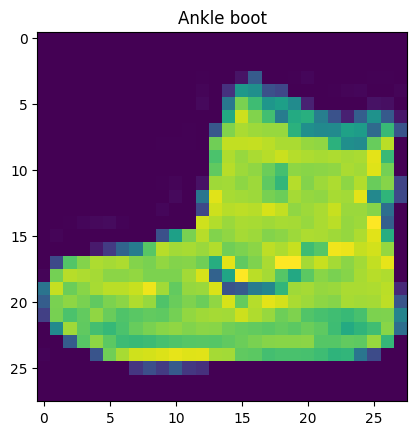

In [10]:
image, label = train_data[0]
print(f"Lets see our image{image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

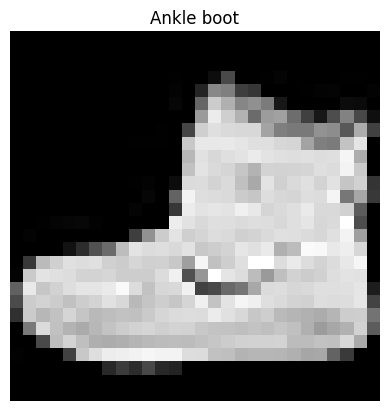

In [11]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)

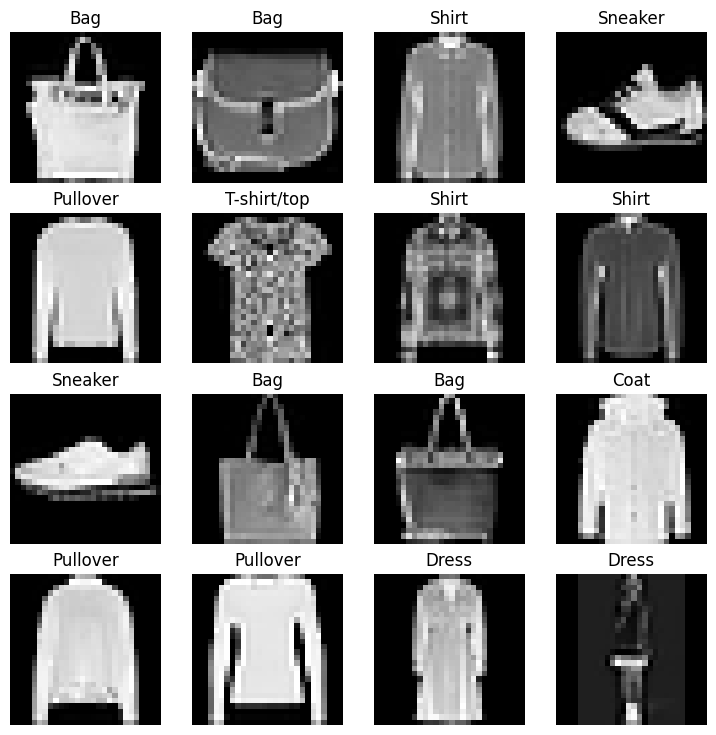

In [12]:
# Plor more images
#torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(low = 0, high = len(train_data), size = (1, )).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False)

Do you think these items of clothing (images) could be modelled with pure linear lines? Do you think we'll need non-linearities?

### 2. Prepare DataLoader

Right now our data is in the form of PyTorch Datasets.

Recall a DataLoader turns our dataset into a Python Iterable.

More specifically, we want to turn our data intop mini-batches.

Why would we do this?

1. It is more computationally efficient, as in your computer hardware may not be able to look (store in memory) at 6000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch.

For more on mini-batches, feel free to research more on the topic (optimizers, gradient descent, mini-batch).


In [13]:
from torch.utils.data import DataLoader

#Setup the batch_size hyperparameters
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle = True)


test_dataloader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bb6a6457850>,
 <torch.utils.data.dataloader.DataLoader at 0x7bb6b41e4fd0>)

In [14]:
# Let's check out what we've created
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7bb6a6457850>, <torch.utils.data.dataloader.DataLoader object at 0x7bb6b41e4fd0>)
length of train dataloader: 1875 batches of 32
length of test dataloader: 313 batches of 32


In [15]:
60000/32

1875.0

In [16]:
# Check out whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 3, label shape: torch.Size([])


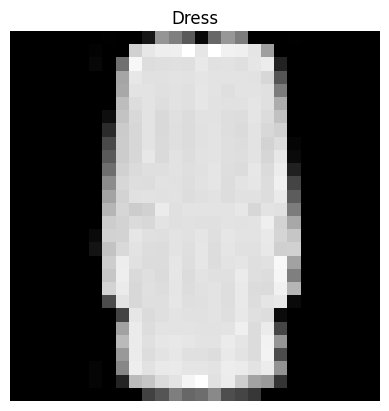

In [17]:
# Show a sample
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=(1, )).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis("off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label shape: {label.shape}")

### 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experimients, its best practice to start with a baseline model.

A baseline model is a simple model you will try and improve up upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [18]:
# Create a flatten flatten layer
flatten_model =  nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening {x.shape} -> [color_channels, height, width]")
print(f"shape after flattening {output.shape} -> [color_channels, height * width]")
#print(x)

Shape before flattening torch.Size([1, 28, 28]) -> [color_channels, height, width]
shape after flattening torch.Size([1, 784]) -> [color_channels, height * width]


In [19]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
              input_shape: int,
              hidden_units: int,
              output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [20]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape = int(28*28), # this is 28 by 28
    hidden_units = 10, # how many units in the hidden layer
    output_shape = len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [22]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics.

* Loss function - since we're working with multi-class data, our loss function will be `nn.crossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric.

In [23]:
import requests
from pathlib import Path

# Download
if Path("helper_functions.py").is_file():
  print("helper functions.py already exists, skipping download..")
else:
  print("Downloading helper functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [24]:
# Import the accuracy metric
from helper_functions import accuracy_fn

In [25]:
accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

In [26]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

### 3.2 Creating a function to time our experiments.

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values, etc).
2. How fast it runs

In [27]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end: float,
                     device: torch.device = None):
  '''
  Prints the difference between start and end time
  '''
  total_time = end - start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [28]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start = start_time, end = end_time, device = "cpu")

Train time on cpu : 0.000 seconds


3.056700001025092e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening
5. Time it all (for fun).

In [29]:
# Import tqdm for progress bar
from tqdm.auto import tqdm # gonna recognize what environment our computer is using, giving us best progress bar

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (We'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  ###Traininig
  train_loss = 0
  # Add a loop to through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
      print(f"Looked at: {batch * (len(X))}/{len(train_dataloader.dataset)}")

  # Adjust for our training loss to get average per batch, per epoch.
  train_loss /= len(train_dataloader)

  ## Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss = loss_fn(test_pred, y_test)

      # 3. Calculate accuracy (True labels and true values in the same format)
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

    # Calculate the test loss averager per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out whats happening
  print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                            end = train_time_end_on_cpu,
                                            device = "cpu")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train loss: 0.59039 | Test loss: 0.00098 | Test acc: 82.04
Epoch: 1
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train loss: 0.47633 | Test loss: 0.00088 | Test acc: 83.20
Epoch: 2
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train loss: 0.45503 | Test loss: 0.00105 | Test acc: 83.43
Train time on cpu : 29.412 seconds


In [30]:
str(next(model_0.parameters()).device)

'cpu'

In [31]:
print(torch.empty(3, dtype=torch.long).random_(5))
print(torch.randn(3, 5).softmax(dim = 1))

tensor([2, 1, 4])
tensor([[0.0244, 0.0770, 0.2156, 0.3114, 0.3716],
        [0.1729, 0.0646, 0.0431, 0.1377, 0.5817],
        [0.3126, 0.0526, 0.1005, 0.4975, 0.0368]])


### 4. Make predictions anf get Model 0 results

In [32]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  '''
  Returns a dictionary containing the results of model predicting on data_loader
  '''
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      #Accumulate the loss and accc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # Scale the loss and acc to find the average loss-acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # Only works when model was created with model class name
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test data set
model_0_results = eval_model(
    model = model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

print(model_0_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}


## 5. Setup device agnostic-code (for using a GPU if there is one)

In [33]:
torch.cuda.is_available()

False

In [34]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [35]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

We learned about the power of non-linearity in notebook 02, link: https://www.learnpytorch.io/02_pytorch_classification/

In [36]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )

  def forward(self, x:torch.Tensor):
    return self.layer_stack(x)

In [37]:
# Create an isntance of model 1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = FashionMNISTModelV1(
    input_shape = int(28*28), # this is the output of the flatten after our 28*28 unitss
    hidden_units = 10,
    output_shape = len(class_names)
).to(device) # Send to the GPU if it's available

print(next(model_1.parameters()).device)

cpu


In [38]:
device

'cpu'

### 6.1 Setup loss, optimizer ane evaluation metrics

In [39]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.SGD(params = model_1.parameters(), # tries to update our model's parameters to reduce the loss
                            lr = 0.1)

### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [40]:
def train_step(model: nn.Module,
               data_loader:DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  '''
  Performs training with model trying to learn on data_laoder
  '''
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data in target.device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss and accuracy per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Adjust for our training loss and acc to get average per batch, per epoch.
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"%Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [41]:
def test_step(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device):
  '''
  Performs a testing loop step on model going over data_loader
  '''
  test_loss, test_acc = 0, 0

  #Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1)) # go from logits -> prediction labels

    # Scale the test_loss and test_acc to find the average test_loss-test_acc per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")


In [42]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

#Set epochs
epochs = 3

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n--------")

  # Perform a batch training step
  train_step(model = model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  # Perform a batch test step
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

Epoch: 0
--------
%Train loss: 1.09199 | Train acc: 61.34%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
--------
%Train loss: 0.73779 | Train acc: 73.69%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.72300 | Test acc: 74.24%

Epoch: 2
--------
%Train loss: 0.66776 | Train acc: 76.08%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.68743 | Test acc: 75.66%

Train time on cpu : 29.060 seconds


In [43]:
# Get model 1 results dictionary
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
  '''
  Returns a dictionary containing the results of model predicting on data_loader
  '''
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make our data device agnostic
      X, y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      #Accumulate the loss and accc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # Scale the loss and acc to find the average loss-acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # Only works when model was created with model class name
          "model_loss": loss.item(),
          "model_acc": acc}

model_1_results = eval_model(
    model = model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6874349117279053,
 'model_acc': 75.65894568690096}

In [44]:
# Print model 0 results and train time on CPU
print(model_0_results)
45
print(total_train_time_model_0)

# Print model 1 train time on GPU
print(model_1_results)
print(total_train_time_model_1)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}
29.411504989000008
{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.6874349117279053, 'model_acc': 75.65894568690096}
29.059729227999995


**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms compute capability than the GPU (normally, when CPU is more modern).

For more understanding, read here: https://horace.io/brrr_intro.html

## Model 2: Building a Convolutional Neural Network (CNN):

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To know what's happening in a CNN, join this website: https://poloclub.github.io/cnn-explainer/

In [45]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  '''
  Model Architecture that replicates the TinyVGG
  model from CNN explainer website.
  '''
  def __init__(self,input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      # Create a conv layer: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride = 1,
                padding=1), # Values we can set ourselves in our NN's are called hyperparameters
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1), # Values we can set ourselves in our NN's are called hyperparameters
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7, # There's a trick to calculating this ...
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape conv_1{x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape conv_2{x.shape}")
    x = self.classifier(x)
    # print(f"Classifier shape {x.shape}")
    return x

In [46]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

In [47]:
print(img.unsqueeze(0).shape)
model_2(img.unsqueeze(0).to(device))

torch.Size([1, 1, 28, 28])


tensor([[ 4.1761e-02, -6.8538e-02,  5.4496e-02, -3.4099e-02, -4.5360e-03,
          1.6471e-02, -9.3719e-05, -1.9384e-02,  2.6878e-02,  7.1455e-03]],
       grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()`

See the documentation for `nn.Conv2d()` here - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [48]:
torch.manual_seed(42)

#Create a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single Image shape: {test_image.shape}")
print(f"Test_image: {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single Image shape: torch.Size([3, 64, 64])
Test_image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [49]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [50]:
# Create a single layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size=(3, 3),
                       stride = 1,
                       padding = 1)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
print(test_image.shape)
print(conv_output.shape)
conv_outputs = conv_layer(images)
print(images.shape)
print(conv_outputs.shape)

torch.Size([3, 64, 64])
torch.Size([10, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 10, 64, 64])


### 7.2 Stepping through `nn.MaxPool2d()`.

Link: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [51]:
# Print out original image shape without unsqueezed dimension
print(f"Test Image original shape: {test_image.shape}")
print(f"Test Image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a smaple nn.MaxPool2d()
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

#Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim = 0))
print(f"Shape after going thought conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max_pool_layer
test_image_through_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through max_pool_layer(): {test_image_through_pool.shape}")

Test Image original shape: torch.Size([3, 64, 64])
Test Image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going thought conv_layer(): torch.Size([1, 10, 64, 64])
Shape after going through max_pool_layer(): torch.Size([1, 10, 32, 32])


In [52]:
test_image.shape

torch.Size([3, 64, 64])

In [53]:
torch.manual_seed(42)
# Create a random tensor witha  similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

#Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nRandom tensor:\n {random_tensor}")
print(f"\nRandom tensor shape:\n {random_tensor.shape}")
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"\nMax pool tensor shape:\n {max_pool_tensor.shape}")


Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

Random tensor shape:
 torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])

Max pool tensor shape:
 torch.Size([1, 1, 1, 1])


## 7.3 Setup a loss function and optimizer for `model_2`

In [54]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [55]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_model_2 = timer()

#Set epochs
epochs = 3

# Create optimization and evaluation loop using train_step() and test_step()
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-----------")

  #Perform a batch training step
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  #Perform a batch test step
  test_step(model = model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)

#Calculate the training time
train_time_end_on_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_model_2,
                                            end=train_time_end_on_model_2,
                                            device=device)

Epoch: 0
-----------
%Train loss: 0.59518 | Train acc: 78.38%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.39500 | Test acc: 85.99%

Epoch: 1
-----------
%Train loss: 0.36421 | Train acc: 86.86%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.38940 | Test acc: 86.13%

Epoch: 2
-----------
%Train loss: 0.32472 | Train acc: 88.31%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.34938 | Test acc: 87.46%

Train time on cpu : 161.715 seconds


In [56]:
model_2_results = eval_model(
    model = model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device = device
)

print(model_2_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.34938228130340576, 'model_acc': 87.46006389776358}


In [57]:
print(model_0_results)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}


In [58]:
print(model_1_results)

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.6874349117279053, 'model_acc': 75.65894568690096}


## 8 Compare model results and training time

In [59]:
import pandas as pd
data_dict = [model_0_results,
             model_1_results,
             model_2_results]
compare_results = pd.DataFrame(data_dict)
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.687435,75.658946
2,FashionMNISTModelV2,0.349382,87.460064


In [60]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
print(compare_results)

            model_name  model_loss  model_acc  training_time
0  FashionMNISTModelV0    0.476639  83.426518      29.411505
1  FashionMNISTModelV1    0.687435  75.658946      29.059729
2  FashionMNISTModelV2    0.349382  87.460064     161.715026


Text(0, 0.5, 'Model')

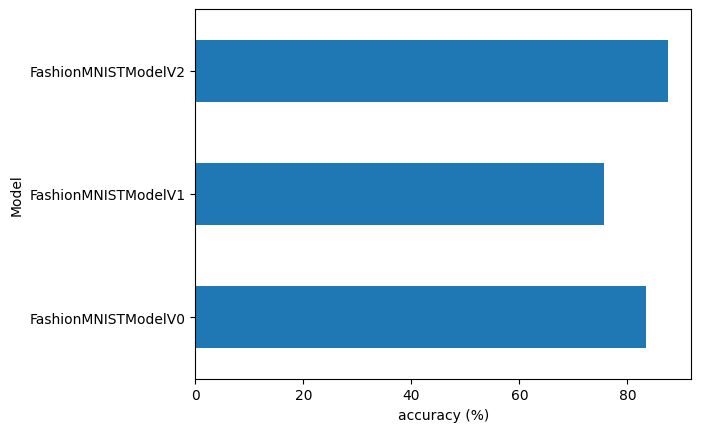

In [61]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy (%)")
plt.ylabel("Model")

## 9 Make and evaluate random predictions with best model

In [62]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      #Prepare the sample, (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu().detach())

  # Stack tge pred_probs to turn list into a tensor
  return torch.stack(pred_probs)


In [63]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
print(test_samples[0].shape)
print(test_labels[0])

torch.Size([1, 28, 28])
5


Text(0.5, 1.0, 'Sandal')

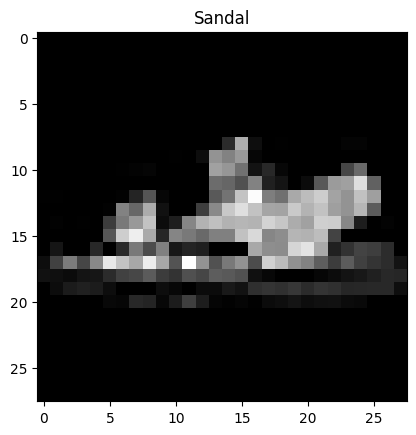

In [64]:
plt.imshow(test_samples[0].squeeze(), cmap = "gray")
plt.title(class_names[test_labels[0]])

In [65]:
# Make predictions
pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# View the first two prediction probabilities
pred_probs[:2]

tensor([[2.9483e-06, 5.7013e-06, 6.5582e-06, 2.9343e-05, 1.7277e-05, 9.6090e-01,
         3.5713e-07, 3.8812e-02, 7.9600e-05, 1.4431e-04],
        [8.9220e-01, 7.0377e-06, 2.6075e-04, 3.8861e-03, 1.7035e-04, 3.7859e-08,
         1.0307e-01, 3.4768e-07, 4.0385e-04, 5.8629e-08]])

In [66]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([5, 0, 6, 9, 9, 8, 7, 8, 3])

In [67]:
test_labels

[5, 0, 0, 9, 9, 8, 7, 8, 3]

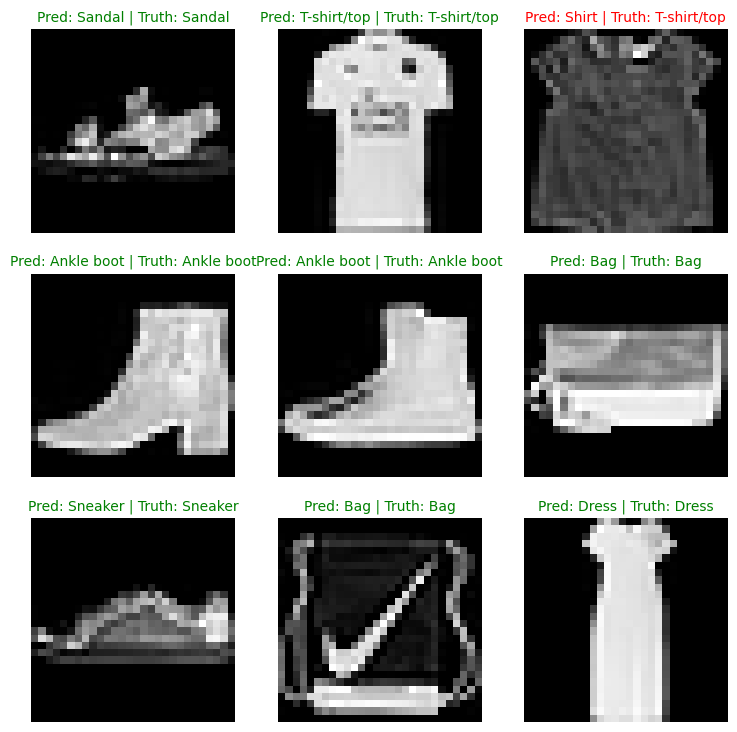

In [68]:
# Plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  #Create a subplot
  plt.subplot(nrows, ncols, i+1)

  #Plot the target image
  plt.imshow(sample.squeeze(), cmap = "gray")

  #Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  #Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  #Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  #Check for equality between pred and truth, and change colors between them
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, color = "g") # green if pred == truth
  else:
    plt.title(title_text, fontsize = 10, color = "r") # red if pred != truth\

  plt.axis("off")

## 10 Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluation your classification models visually: https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix` link: https://torchmetrics.readthedocs.io/en/v0.8.2/classification/confusion_matrix.html
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`
https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [69]:
# Import tqdm.auto
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = "Making predictions..."):
    # Sending data to device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model_2(X)

    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)

    # Append to y_preds
    y_preds.append(y_pred.cpu())

# Concatanate them
#print(y_preds)
y_preds_tensor = torch.cat(y_preds)
print(y_preds_tensor[:3])

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1])


In [70]:
y_preds_tensor.shape

torch.Size([10000])

In [71]:
try:
  import torchmetrics, mlxtend
  print(f"torchmetrics version: {torchmetrics.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= "mltxtend version should be 0.19.0 or higher")
  print(f"mlxtend version: {mlxtend.__version__}")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"torchmetrics version: {torchmetrics.__version__}")
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [72]:
print(test_data.targets)
print(y_preds_tensor)

tensor([9, 2, 1,  ..., 8, 1, 5])
tensor([9, 2, 1,  ..., 8, 1, 2])


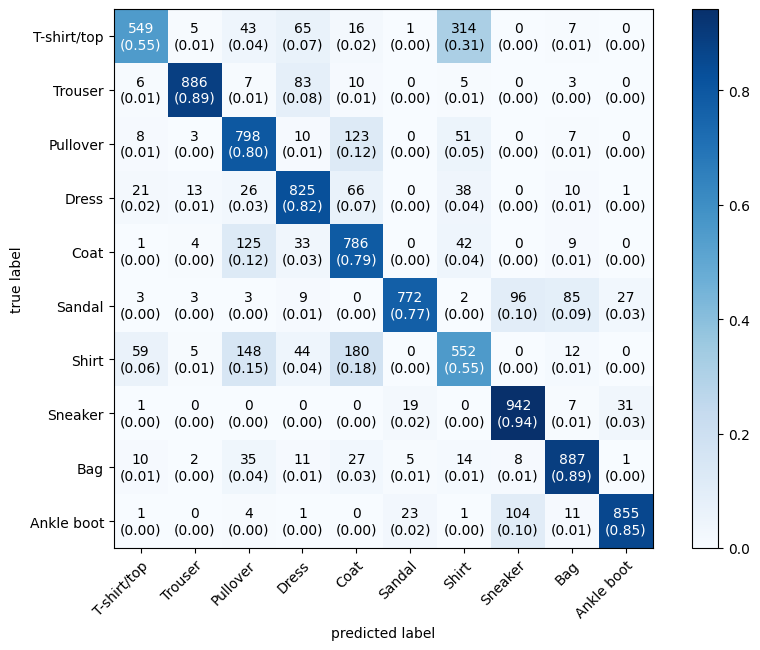

In [74]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "multiclass", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_preds_tensor, target = test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize = (10, 7),
                                show_normed = True,
                                colorbar = True,
                                cmap = plt.cm.Blues)

## 11. Save and load best performing model

In [76]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok=True)

#Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [77]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units = 10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Send the model to target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [79]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model = loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device = device
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [80]:
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.34938228130340576,
 'model_acc': 87.46006389776358}

In [81]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.34938228130340576,
 'model_acc': 87.46006389776358}

In [82]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol = 1e-02)

tensor(True)